In [7]:
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langchain_community.tools import TavilySearchResults
from typing import TypedDict, Annotated , Literal
from langgraph.graph import add_messages, StateGraph, END
from dotenv import load_dotenv
from langgraph.prebuilt import ToolNode

load_dotenv()

class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro")
llm_with_tools = llm.bind_tools(tools=tools)

def model(state: AgentState):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])], 
    }

def tools_router(state: AgentState) -> Literal["tool_node",END]:
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return END
    

tool_node = ToolNode(tools=tools)

graph = StateGraph(AgentState)

graph.add_node("model", model)
graph.add_node("tool_node", tool_node)
graph.set_entry_point("model")

graph.add_conditional_edges("model", tools_router)
graph.add_edge("tool_node", "model")

app = graph.compile()


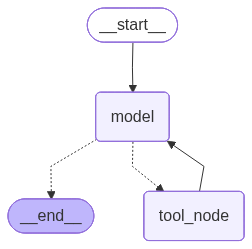

In [8]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [13]:
input = {
    "messages": ["What's the current weather in Bangalore?"]
}

events = app.stream(input=input, stream_mode="values")

for event in events: 
    print(event["messages"])

[HumanMessage(content="What's the current weather in Bangalore?", additional_kwargs={}, response_metadata={}, id='7decdf39-d38f-4bd1-92c9-00ea11eabd59')]
[HumanMessage(content="What's the current weather in Bangalore?", additional_kwargs={}, response_metadata={}, id='7decdf39-d38f-4bd1-92c9-00ea11eabd59'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "current weather in Bangalore"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-pro', 'safety_ratings': []}, id='run--4850e882-f6b2-4461-8115-e71eb082edf3-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Bangalore'}, 'id': '02524b8e-ae71-4f93-8c5a-7ee2aac16804', 'type': 'tool_call'}], usage_metadata={'input_tokens': 83, 'output_tokens': 484, 'total_tokens': 567, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reason

In [14]:
input = {
    "messages": ["What's the current weather in Bangalore?"]
}

events = app.stream(input=input, stream_mode="updates")

for event in events: 
    print(event)

{'model': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "current weather in Bangalore"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-pro', 'safety_ratings': []}, id='run--d76f20b2-b017-4d42-acda-ad3b2635493c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Bangalore'}, 'id': 'e3d0c956-b0e6-473e-b815-5dea640bc084', 'type': 'tool_call'}], usage_metadata={'input_tokens': 83, 'output_tokens': 245, 'total_tokens': 328, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 221}})]}}
{'tool_node': {'messages': [ToolMessage(content='[{"title": "Weather in Bengaluru in October 2025 - Detailed Forecast", "url": "https://www.easeweather.com/asia/india/karnataka/bangalore-urban/bengaluru/october", "content": "easeweather.com\\nIndia weather\\n\\n# Weat

In [15]:
input = {
    "messages": ["Hi, how are you?"]
}

events = app.astream_events(input=input, version="v2")

async for event in events: 
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi, how are you?']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '2e1c3757-f215-4a78-ab85-442202f7794a', 'metadata': {}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi, how are you?', additional_kwargs={}, response_metadata={}, id='b28fd143-8e77-4cb1-aa92-ce31e71c600f')]}}, 'name': 'model', 'tags': ['graph:step:1'], 'run_id': 'fb196c1f-2631-4166-9611-7b762c6a7a80', 'metadata': {'langgraph_step': 1, 'langgraph_node': 'model', 'langgraph_triggers': ('branch:to:model',), 'langgraph_path': ('__pregel_pull', 'model'), 'langgraph_checkpoint_ns': 'model:aa10dc12-3453-2e96-a7a3-cb15c373ad82'}, 'parent_ids': ['2e1c3757-f215-4a78-ab85-442202f7794a']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi, how are you?', additional_kwargs={}, response_metadata={}, id='b28fd143-8e77-4cb1-aa92-ce31e71c600f')]]}}, 'name': 'ChatGoogleGenerativeAI', '

In [16]:
input = {
    "messages": ["Hi, how are you?"]
}

events = app.astream_events(input=input, version="v2")

async for event in events: 
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="", flush=True)

I am doing well, thank you for asking! I am a large language model, trained by Google. How are you today?